# Software Vulnerability Detection using Deep Learning (Experiment Replication)

### Multicolumn experiment (All CWEs and others)

* This is from Russell et. al work (Automated Vulnerability Detection in Source Code Using Deep Representation Learning) https://arxiv.org/abs/1807.04320
* Datasets downloaded from https://osf.io/d45bw/
* Datasets distribution: Training (80%), Validation (10%), Testing (10%)
* The dataset consists of the source code of 1.27 million functions mined from open source software, labeled by static analysis for potential vulnerabilities.
* Each function's raw source code, starting from the function name, is stored as a variable-length UTF-8 string. Five binary 'vulnerability' labels are provided for each function, corresponding to the four most common CWEs in our data plus all others: 
 * CWE-120 (3.7% of functions)
 * CWE-119 (1.9% of functions)
 * CWE-469 (0.95% of functions)
 * CWE-476 (0.21% of functions)
 * CWE-other (2.7% of functions)
* Functions may have more than one detected CWE each.
* Python 3.6 and Tensorflow 2.0.0

In [ ]:
import mlflow

In [ ]:
import os 

## Pre-processing

Converting the HDF5 files for training/validation/testing datasets to python pickle for ease of future usage

In [ ]:
import h5py
import pandas as pd


In [ ]:
h5py.__version__

'2.10.0'

In [ ]:
import tensorflow as tf
import numpy as np
tf.__version__

'2.8.2'

In [ ]:
tf.keras.__version__

'2.4.0'

In [ ]:
#mydf['CWE-276']=list(data['CWE-276']); mydf['CWE-532']=list(data['CWE-532']); mydf['CWE-295']=list(data['CWE-295']); mydf['CWE-89']=list(data['CWE-89']); mydf['CWE-327']=list(data['CWE-327']);  mydf['CWE-312']=list(data['CWE-312']);  mydf['CWE-330']=list(data['CWE-330']);  mydf['CWE-619']=list(data['CWE-619'])  ;  mydf['CWE-200']=list(data['CWE-200']) ;  mydf['CWE-749']=list(data['CWE-749']) ;  mydf['CWE-919']=list(data['CWE-919']) ;  mydf['CWE-250']=list(data['CWE-250']) ;  mydf['CWE-502']=list(data['CWE-502']) 

### Importing processed datasets

In [ ]:
data=pd.read_csv("df_merge_without_dupes_multiclass_balanced_shuffled.csv")


In [ ]:
data.tail()

,Name,NV,CWE-89,CWE-327,CWE-312,CWE-276,Unknown-CWE
46387,private static final String ERROR_CODE_FIELD_K...,0,0,0,1,0,0
46388,getSettings().setJavaScriptEnabled(true);,0,0,0,0,0,1
46389,"public boolean decryptAPPFile(Context context,...",0,0,1,0,0,0
46390,public static final String VIEWABLE_PARAMS_KEY...,0,0,0,1,0,0
46391,public static String a(String str) \n t...,0,0,1,0,0,0


In [ ]:
data['NV'].value_counts()

0    38660
1     7732
Name: NV, dtype: int64

In [ ]:

print(data['CWE-312'].value_counts())



0    38660
1     7732
Name: CWE-312, dtype: int64


In [ ]:
#shuffled = data.sample(frac=1).reset_index(drop=True) #for randomizing data

In [ ]:
#shuffled.head()

In [ ]:
#shuffled[shuffled.columns[0:14]]

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x_tmp, x_test, y_tmp, y_test = train_test_split(data["Name"], data[data.columns[1:14]], test_size=0.1, random_state=42)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_tmp, y_tmp, test_size=0.11, random_state=42)

In [ ]:
#data['Impact'].value_counts()

In [ ]:
#x_test

In [ ]:
y_train.value_counts()

NV  CWE-89  CWE-327  CWE-312  CWE-276  Unknown-CWE
0   0       1        0        0        0              6236
    1       0        0        0        0              6218
    0       0        0        1        0              6199
                              0        1              6195
                     1        0        0              6167
1   0       0        0        0        0              6144
dtype: int64

## Learning Phase

### Importing libraries

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics
import pickle

#from numba import jit, cuda

print("Tensorlfow version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Tensorlfow version:  2.4.4
Eager mode:  True
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is available


2022-09-23 14:14:59.236788: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-23 14:14:59.237369: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-09-23 14:14:59.238263: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-09-23 14:15:00.165012: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:19:00.0 name: Quadro GV100 computeCapability: 7.0
coreClock: 1.627GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 810.62GiB/s
2022-09-23 14:15:00.166243: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found dev

### Setting static and global variables

In [ ]:
# Generate random seed
#myrand=np.random.randint(1, 99999 + 1)
myrand=71926
np.random.seed(myrand)
tf.random.set_seed(myrand)
print("Random seed is:",myrand)

Random seed is: 71926


In [ ]:
# Set the global value
WORDS_SIZE=30000
INPUT_SIZE=512
NUM_CLASSES=6
MODEL_NUM=0
EPOCHS=50

### Importing processed datasets

### Tokenizing the source codes

In [ ]:
# token_list_train = [i.decode("utf-8") for i in x_train]
# token_list_test = [i.decode("utf-8") for i in x_test]
# token_list_val = [i.decode("utf-8") for i in x_val]


In [ ]:
# t = []
# if(1==1):
#     t.append([1,0])
# t

In [ ]:
#token_list_train[0]
# token_list_test[0]
# token_list_val[0]

In [ ]:
# # Tokenizer with word-level(text to vectors)
# tokenizer_train = tf.keras.preprocessing.text.Tokenizer(char_level=False)
# tokenizer_test = tf.keras.preprocessing.text.Tokenizer(char_level=False)
# tokenizer_val = tf.keras.preprocessing.text.Tokenizer(char_level=False)
# #tokenizer.fit_on_texts(list(x_all))
# # tokenizer.fit_on_texts(list(str(x_all)))
# tokenizer_train.fit_on_texts(list(x_train))
# tokenizer_test.fit_on_texts(list(x_test))
# tokenizer_val.fit_on_texts(list(x_val))
# # del(x_all)
# print('Number of tokens of x_train: ',len(tokenizer_train.word_counts))
# print('Number of tokens of x_test: ',len(tokenizer_test.word_counts))
# print('Number of tokens of x_val: ',len(tokenizer_val.word_counts))

In [ ]:
# # Reducing to top N words
# tokenizer_train.num_words = WORDS_SIZE
# tokenizer_test.num_words = WORDS_SIZE
# tokenizer_val.num_words = WORDS_SIZE

In [ ]:
#tokenizer_train.word_counts.items()


In [ ]:
#tokenizer_test.word_counts.items()

In [ ]:
#tokenizer_val.word_counts.items()

In [ ]:
# # Top 10 words
# sorted(tokenizer_train.word_counts.items(), key=lambda x:x[1], reverse=True)[0:10]
# sorted(tokenizer_test.word_counts.items(), key=lambda x:x[1], reverse=True)[0:10]
# sorted(tokenizer_val.word_counts.items(), key=lambda x:x[1], reverse=True)[0:10]

In [ ]:
# type(list(shuffled['Name'])[0])

In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

In [ ]:
# PRE_TRAINED_MODEL_NAME = 'bert-large-uncased' to try

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
tokenizer

PreTrainedTokenizer(name_or_path='bert-base-cased', vocab_size=28996, model_max_len=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

### Create sequence files from the tokens

In [ ]:
np.array(x_train)[0]

'private static final String MARK_READ_MESSAGES_KEY = "mark_as_read";'

In [ ]:
x_train_tokenized_list = []

In [ ]:
x_train_t = []
x_val_t = []
x_test_t = []

In [ ]:
for set_, tokenized_set in zip([x_train.to_numpy(), x_val.to_numpy(), x_test.to_numpy()], [x_train_t, x_val_t, x_test_t]):
  for code_sample in set_:
    tokenized_sample = tokenizer.encode_plus(
            code_sample,
            truncation=True,
            add_special_tokens=True,
            max_length=512,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
          #   return_tensors='pt',
          )['input_ids']

    tokenized_set.append(tokenized_sample)

  tokenized_set = np.array(tokenized_set)

In [ ]:
x_train_t = np.array(x_train_t)
x_val_t = np.array(x_val_t)
x_test_t = np.array(x_test_t)

In [ ]:
tokenized_set

array([[  101,  1470,  1509, ...,     0,     0,     0],
       [  101,  1470,   140, ...,     0,     0,     0],
       [  101,  1470, 15048, ...,     0,     0,     0],
       ...,
       [  101,  2029, 12182, ...,     0,     0,     0],
       [  101,  1470, 13340, ...,     0,     0,     0],
       [  101,  1470,  5619, ...,   170,   113,   102]])

In [ ]:
x_train_t[0]

In [ ]:
x_val_t[0]

array([  101,  1470,  5619,   170,   113,   114,   138, 10582,  1183,
        2162,  1776,  9245,  2162,  1776,   134,  1207,   138, 10582,
        1183,  2162,  1776,   113,   114,   132,   140,  7719,  1766,
        7158,  4880, 10232,  1183,   134,  1243,  2924, 27770,  2137,
        6575, 14017,   113,   114,   119,  7158,  4880, 10232,  1183,
         113,   107, 12342, 17516, 16647,   115,   143, 21564,  2107,
         188,  4206, 14017,   107,   117, 26280,   114,   132,  1191,
         113,   106,  7158,  4880, 10232,  1183,   119,  1815,  1942,
        1186,  2271, 11836,  1204,   113,   114,   114,  1862,  9245,
        2162,  1776,   132,  1202,   188,   188,  2559,  1813,   134,
        1207,   188,   113,   114,   132,   188,  2559,  1813,   119,
         170,   113,  1130,  1566,  2895,   119,  2860,  2346,  2087,
         113,  1130,  1566,  2895,   119, 14247,  2217,  2240,  2227,
         113,  7158,  4880, 10232,  1183,   119,  1243,  1708, 28108,
         113,   121,

In [ ]:
len(x_train[0])

5889

In [ ]:
x_train.shape

(37159,)

In [ ]:
x_test.shape

(4640,)

In [ ]:
# Example data
#test.iloc[0:2,:15]
#x_test

### One-Hot-Enconding (OHE) on the datasets

In [ ]:
#train.iloc[:,2][5]
#x_train

In [ ]:
y_train.head()

,NV,CWE-89,CWE-327,CWE-312,CWE-276,Unknown-CWE
17299,0,0,0,1,0,0
24886,0,0,0,0,0,1
21778,0,1,0,0,0,0
42405,0,0,0,0,1,0
26240,1,0,0,0,0,0


In [ ]:
x_train

17299    private static final String MARK_READ_MESSAGES...
24886    public static final String ID_RSA = "1.2.840.1...
21778    public abstract void migrate(SQLiteDatabase sQ...
42405    public static File getUiniversalImageFile() \n...
26240    public String javass(String str, String str2, ...
                               ...                        
37107    private String getAdId() \n        MMWebView w...
20168    public String doInBackground(String... params)...
1316     public Intent registerReceiver(BroadcastReceiv...
12088    private File h() \n        if (!bv.a(this.d, f...
3371     public void initBanner() \n        if (!this.i...
Name: Name, Length: 37159, dtype: object

In [ ]:
y_train_array = np.array(y_train)

In [ ]:
y_train_array.shape

(37159, 6)

In [ ]:
y_test_array = np.array(y_test)

In [ ]:
y_val_array = np.array(y_val)

In [ ]:
y_train_array.shape

(37159, 6)

In [ ]:
y_test_array[0][0:10]

array([0, 1, 0, 0, 0, 0])

In [ ]:
# Example data
y_test_array[0].__len__()

6

In [ ]:
y_train_array[0]

array([0, 0, 0, 1, 0, 0])

In [ ]:
#y_test_array[0][1:10]

In [ ]:
#y_train_array

In [ ]:
len(y_train_array)

37159

### Model Definition (CNN with Gaussian Noise and 5 Output Splits)

In [ ]:
strategy = tf.distribute.MirroredStrategy()

In [ ]:
# Create a random weights matrix
# random_weights = np.random.normal(size=(WORDS_SIZE, 256),scale=0.01)

In [ ]:
# Must use non-sequential model building to create branches in the output layer
with strategy.scope():
  inp_layer = tf.keras.layers.Input(shape=(512,))
  mid_layers = tf.keras.layers.Embedding(input_dim = 1000,
                                      output_dim = 256,
                                      # weights=[random_weights],
                                      embeddings_initializer='he_normal',
                                      input_length = 512)(inp_layer)

  mid_layers = tf.keras.layers.Convolution1D(filters=512, kernel_size=(9), padding='same', activation='relu')(mid_layers)
  mid_layers = tf.keras.layers.MaxPool1D(pool_size=6)(mid_layers)
  mid_layers = tf.keras.layers.Dropout(0.5)(mid_layers)
  mid_layers = tf.keras.layers.Flatten()(mid_layers)
  mid_layers = tf.keras.layers.Dense(64, activation='relu')(mid_layers)
  mid_layers = tf.keras.layers.Dense(32, activation='relu')(mid_layers)

  mid_layers = tf.keras.layers.Dense(32, activation='relu')(mid_layers)
  mid_layers = tf.keras.layers.Dense(32, activation='relu')(mid_layers)

  mid_layers = tf.keras.layers.Dense(16, activation='relu')(mid_layers)
  mid_layers = tf.keras.layers.Dense(16, activation='relu')(mid_layers)
  mid_layers = tf.keras.layers.Dense(16, activation='relu')(mid_layers)
  output1 = tf.keras.layers.Dense(6, activation='softmax')(mid_layers)





  model = tf.keras.Model(inp_layer, output1)



  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate=1e-2,
      decay_steps=10000,
      decay_rate=0.9)





  sgd = tf.keras.optimizers.SGD(learning_rate=lr_schedule)



  ## Compile model with metrics
  model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

print("CNN model built: ")
model.summary()

CNN model built: 
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 512)]             0         
                                                                 
 embedding_5 (Embedding)     (None, 512, 256)          256000    
                                                                 
 conv1d_5 (Conv1D)           (None, 512, 512)          1180160   
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 85, 512)          0         
 1D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 85, 512)           0         
                                                                 
 flatten_5 (Flatten)         (None, 43520)             0         
                                         

In [ ]:
model.inputs

[<KerasTensor: shape=(None, 10000) dtype=float32 (created by layer 'input_3')>]

In [ ]:
np.random.rand(10_000,512).shape

(10000, 512)

In [ ]:
batch = np.random.randint(1000, size=(32, 10))

In [ ]:
batch.shape

(1, 10000, 512)

In [ ]:
model.predict(batch)

array([[0.1662452 , 0.1666007 , 0.16717035, 0.1664548 , 0.16639969,
        0.16712931],
       [0.1662452 , 0.1666007 , 0.16717035, 0.1664548 , 0.16639969,
        0.16712931],
       [0.1662452 , 0.1666007 , 0.16717035, 0.1664548 , 0.16639969,
        0.16712931],
       ...,
       [0.16624522, 0.1666007 , 0.16717035, 0.1664548 , 0.16639969,
        0.16712931],
       [0.16624522, 0.1666007 , 0.16717035, 0.1664548 , 0.16639969,
        0.16712931],
       [0.16624522, 0.1666007 , 0.16717035, 0.1664548 , 0.16639969,
        0.16712931]], dtype=float32)

### Tensorboard Callbacks

In [ ]:
## Create TensorBoard callbacks

callbackdir = os.getcwd()
# tbCallback = tf.keras.callbacks.TensorBoard(log_dir=callbackdir, 
#                          histogram_freq=1,
#                          embeddings_freq=1,
#                          write_graph=True, 
#                          write_images=True)

#tbCallback.set_model(model)
mld = 'model/model-ALL-{epoch:02d}.hdf5'

## Create best model callback
mcp = tf.keras.callbacks.ModelCheckpoint(filepath=mld, 
                                         monitor="val_loss",
                                         save_best_only=True, 
                                         mode='auto', 
                                         save_freq='epoch', 
                                         verbose=1)

In [ ]:
import os 
os.getcwd()

'/home/nova/Lab_individual_works/Rijha/Multi class/4)mlc_bertbasecased-CNN'

### Model Training

In [ ]:
x_train

17299    private static final String MARK_READ_MESSAGES...
24886    public static final String ID_RSA = "1.2.840.1...
21778    public abstract void migrate(SQLiteDatabase sQ...
42405    public static File getUiniversalImageFile() \n...
26240    public String javass(String str, String str2, ...
                               ...                        
37107    private String getAdId() \n        MMWebView w...
20168    public String doInBackground(String... params)...
1316     public Intent registerReceiver(BroadcastReceiv...
12088    private File h() \n        if (!bv.a(this.d, f...
3371     public void initBanner() \n        if (!this.i...
Name: Name, Length: 37159, dtype: object

In [ ]:
#del model

In [ ]:
y_test_array_norm = []
for x in y_test_array:
    y_test_array_norm.append(np.argmax(x))


y_test_array_norm = np.array(y_test_array_norm)

In [ ]:
y_train_array

array([[0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0, 0],
       ...,
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1]])

In [ ]:
LOCAL_BATCH_SIZE = 1070

In [ ]:
# class_weights = [{0: 1., 1: 11.},{0: 1., 1: 11.},{0: 1., 1: 11.},{0: 1., 1: 11.},{0: 1., 1: 11.},{0: 1., 1: 11.},{0: 1., 1: 11.},{0: 1., 1: 11.},{0: 1., 1: 11.},{0: 1., 1: 11.},{0: 1., 1: 11.}]
# class_weights = {
#     0: 0.0,
#     1: 6.6666,
#     2: 6.6666,
#     3: 6.6666,
#     4: 6.6666,
#     5: 6.6666,
#     6: 6.6666,
#     7: 6.6666,
#     8: 6.6666,
#     9: 6.6666,
#     10: 6.6666,
#     11: 6.6666
# }
#mlflow.tensorflow.autolog()
history = model.fit(x = x_train_t,
          y = y_train_array,
           validation_data = (x_val_t, y_val_array),
          epochs = 200,
          batch_size = LOCAL_BATCH_SIZE * strategy.num_replicas_in_sync.,
          verbose = 1,
          #class_weight= class_weight,
          callbacks=[mcp]
          )

with open(f'history/History-ALL-{EPOCHS}EP-CNN', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [ ]:
x_train_t

array([[  101,  2029, 12182, ...,     0,     0,     0],
       [  101,  1470, 12182, ...,     0,     0,     0],
       [  101,  1470, 11108, ...,     0,     0,     0],
       ...,
       [  101,  1470,  1130, ...,     0,     0,     0],
       [  101,  2029, 25647, ...,     0,     0,     0],
       [  101,  1470, 13340, ...,   113,  1243,   102]])

In [ ]:
y_train_array.shape

(37159, 6)

In [ ]:
x_train

17299    private static final String MARK_READ_MESSAGES...
24886    public static final String ID_RSA = "1.2.840.1...
21778    public abstract void migrate(SQLiteDatabase sQ...
42405    public static File getUiniversalImageFile() \n...
26240    public String javass(String str, String str2, ...
                               ...                        
37107    private String getAdId() \n        MMWebView w...
20168    public String doInBackground(String... params)...
1316     public Intent registerReceiver(BroadcastReceiv...
12088    private File h() \n        if (!bv.a(this.d, f...
3371     public void initBanner() \n        if (!this.i...
Name: Name, Length: 37159, dtype: object

### Model Evaluation using Testing Set

In [ ]:
y_train_array

array([[0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0, 0],
       ...,
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1]])

In [ ]:
tf.__version__
h5py.__version__

'2.10.0'

In [ ]:
model = tf.keras.models.load_model("model/model-ALL-46.hdf5")


In [ ]:
results = model.evaluate(x_test_t, y_test_array, batch_size=128)
# for num in range(0,len(model.metrics_names)):
#     print(model.metrics_names[num]+': '+str(results[num]))

2022-09-23 14:21:36.374399: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-09-23 14:21:36.393085: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3699850000 Hz
2022-09-23 14:21:36.684635: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-09-23 14:21:37.360612: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-09-23 14:21:37.417916: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


37/37 [==============================] - 5s 22ms/step - loss: 0.2640 - accuracy: 0.9338


### Check The Evaluation Metrics

In [ ]:
predicted = model.predict(x_test_t)

In [ ]:
#predicted = model.predict(np.expand_dims(x_test[0], axis=0))


In [ ]:
predicted[0]

array([9.3600564e-03, 9.9062645e-01, 7.0293567e-07, 1.5743988e-15,
       2.8419065e-06, 9.9183962e-06], dtype=float32)

In [ ]:
#np.expand_dims(x_test[0], axis=0).shape

In [ ]:
np.where(predicted< 0.5)

(array([   0,    0,    0, ..., 4639, 4639, 4639]),
 array([0, 2, 3, ..., 3, 4, 5]))

In [ ]:
#x_test[6]

In [ ]:
y_test_array[0][0]

0

In [ ]:
predicted = np.squeeze(predicted)

In [ ]:
#len(predicted)

In [ ]:
# pred_test = []

# for col_value in range(0,len(predicted)):
#     if(value>=0.5):
#             #pred_test[col].append([1,0])
#         pred_test[value].append(1)
#     else:
#             #pred_test[col].append([0,1])
#         pred_test[value].append(0)
# #temp=[]
#temp1 = np.array([])

# for col in range(0,len(predicted)):
#     print(pd.value_counts(pred_test[col]))
    #if(pred_test[col]==0):
        #temp1.append([1,0])
    #else:
        #temp1.append([0,1])
#temp.transpose()
training = "Multiclass"
pred_test = []



for ele in predicted:
    pred_test.append(np.argmax(ele))

# for col in range(0,len(predicted)):
#     for row in predicted[col]:
#         if row >= 0.5:
#             #y_pred_test[col].append([1,0])
#             pred_test.append(1)
#         else:
#             pred_test.append(0)
#             #y_pred_test[col].append([0,1])
# for col in range(0,len(pred_test)):
#     print(pd.value_counts(pred_test))

In [ ]:
pred_test.__len__()

4640

In [ ]:
np.argmax(predicted[0])

1

In [ ]:
predicted.shape

(4640, 6)

In [ ]:
predicted[0]

array([9.3600564e-03, 9.9062645e-01, 7.0293567e-07, 1.5743988e-15,
       2.8419065e-06, 9.9183962e-06], dtype=float32)

In [ ]:
#pred_test

In [ ]:
#for
# i = i

In [ ]:
#np.argmax(predicted)

In [ ]:
predicted[predicted > 0.5].shape

(4551,)

In [ ]:
y_test_1 = y_test_array

In [ ]:
'''Y TEST LIST'''

y_pred_test = []


for ele in y_test_1:
    y_pred_test.append(np.argmax(ele))
# y_pred_test = []

# for col in range(0,len(y_test_1)):
#     for row in y_test_1[col]:
#         if row >= 0.5:
#             #y_pred_test[col].append([1,0])
#             y_pred_test.append(1)
#         else:
#             y_pred_test.append(0)
#             #y_pred_test[col].append([0,1])
# for col in range(0,len(y_test_1)):
#     print(pd.value_counts(y_pred_test))


#temp=[]
#temp1 = np.array([])

# for col in range(0,len(predicted)):
#     print(pd.value_counts(pred_test[col]))
    #if(pred_test[col]==0):
        #temp1.append([1,0])
    #else:
        #temp1.append([0,1])
#temp.transpose()

In [ ]:
y_pred_test

[1,
 1,
 0,
 4,
 2,
 0,
 4,
 0,
 0,
 5,
 2,
 2,
 5,
 2,
 4,
 3,
 5,
 4,
 5,
 4,
 0,
 0,
 5,
 3,
 0,
 5,
 4,
 2,
 4,
 4,
 4,
 2,
 4,
 2,
 1,
 1,
 5,
 0,
 3,
 4,
 0,
 0,
 5,
 2,
 1,
 4,
 2,
 3,
 3,
 2,
 4,
 5,
 5,
 0,
 1,
 5,
 1,
 3,
 0,
 3,
 3,
 2,
 3,
 3,
 0,
 0,
 3,
 3,
 1,
 1,
 3,
 1,
 0,
 1,
 5,
 1,
 2,
 0,
 4,
 1,
 2,
 3,
 4,
 4,
 1,
 2,
 2,
 1,
 1,
 2,
 0,
 5,
 5,
 5,
 0,
 1,
 2,
 4,
 4,
 4,
 3,
 4,
 0,
 1,
 3,
 0,
 0,
 2,
 4,
 5,
 1,
 1,
 4,
 2,
 5,
 5,
 1,
 3,
 2,
 2,
 3,
 0,
 3,
 5,
 1,
 5,
 4,
 1,
 2,
 2,
 5,
 4,
 5,
 5,
 3,
 5,
 2,
 3,
 1,
 1,
 0,
 5,
 2,
 2,
 3,
 3,
 0,
 3,
 4,
 3,
 1,
 5,
 1,
 1,
 2,
 0,
 3,
 2,
 4,
 4,
 3,
 1,
 4,
 4,
 1,
 4,
 2,
 5,
 0,
 3,
 4,
 3,
 3,
 1,
 2,
 0,
 3,
 3,
 2,
 5,
 3,
 1,
 1,
 0,
 1,
 2,
 3,
 1,
 1,
 5,
 5,
 5,
 3,
 5,
 4,
 3,
 0,
 2,
 4,
 4,
 2,
 4,
 3,
 1,
 4,
 1,
 2,
 0,
 2,
 5,
 0,
 3,
 2,
 2,
 4,
 1,
 5,
 2,
 1,
 3,
 2,
 2,
 1,
 0,
 4,
 1,
 0,
 2,
 0,
 2,
 1,
 0,
 1,
 5,
 0,
 2,
 2,
 0,
 0,
 0,
 5,
 4,
 1,
 5,
 2,
 2,
 4,
 5,
 4,
 5,


In [ ]:
# y_test_array_norm = []
# for x in y_test_array:
#     y_test_array_norm.append(np.argmax(x))


# y_test_array_norm = np.array(y_test_array_norm)

In [ ]:
#y_test_array_norm

In [ ]:
# pred_test_array_norm = []

# for x in predicted:
#     pred_test_array_norm.append(np.argmax(x))


# pred_test_array_norm = np.array(pred_test_array_norm)

In [ ]:
#y_test_array_norm.shape

In [ ]:
# np.argmax(x)

### Evaluate on the testing set

In [ ]:
#pred_test[0][1]

In [ ]:
#from sklearn.preprocessing import MultiLabelBinarizer

In [ ]:
#y_test = MultiLabelBinarizer().fit_transform(test)
#pred_test= MultiLabelBinarizer().fit_transform(pred_test)


In [ ]:
y_test_array.__len__()

4640

In [ ]:
#pred_test

In [ ]:
y_pred_test.__len__()

4640

5

In [ ]:
#confusion = sklearn.metrics.confusion_matrix(y_true=transformed_test, y_pred=transformed_test)\
# sklearn.metrics.accuracy_score(test[:,1],pred_test[0])

In [ ]:
#pred_test[1][0]

In [ ]:
y_test_array[0]

array([0, 1, 0, 0, 0, 0])

In [ ]:
y_test_array.shape  

(4640, 6)

In [ ]:
predicted.shape

(4640, 6)

In [ ]:
data.columns[1:].to_list()

['NV', 'CWE-89', 'CWE-327', 'CWE-312', 'CWE-276', 'Unknown-CWE']

In [ ]:
#from sklearn.metrics import confusion_matrix
from sklearn.metrics  import multilabel_confusion_matrix

for col in range(0,6):
    print('\nThis is evaluation for column',col)
    #confusion=confusion_matrix(y_true=y_test[:,col], y_pred=pred_test[col-1])
    confusion=multilabel_confusion_matrix(y_true=y_pred_test, y_pred=pred_test)
    # confusion = sklearn.metrics.confusion_matrix(y_true=y_pred_test, y_pred=pred_test)
    #confusion = sklearn.metrics.confusion_matrix(y_true=y_test[col], y_pred=pred_test[col-1])
    print(confusion)
    # print( sklearn.metrics.classification_report(y_true=y_pred_test[col], y_pred=pred_test[col]))
    # tn, fp, fn, tp = confusion.ravel()
    # print('\nTP:',tp)
    # print('FP:',fp)
    # print('TN:',tn)
    # print('FN:',fn)
      ## Performance measure
    print('\nAccuracy: '+ str(sklearn.metrics.accuracy_score(y_true=y_pred_test, y_pred=pred_test)))
    #print('Precision: '+ str(sklearn.metrics.precision_score(y_true=y_pred_test, y_pred=pred_test)))
    # print('Recall: '+ str(sklearn.metrics.recall_score(y_true=y_test_array, y_pred=pred_test)))
    # print('F-measure: '+ str(sklearn.metrics.f1_score(y_true=y_pred_test, y_pred=pred_test)))
    #print('Precision-Recall AUC: '+ str(sklearn.metrics.average_precision_score(y_true=y_test[col], y_score=predicted[col][:,1])))
    #print('AUC: '+ str(sklearn.metrics.roc_auc_score(y_true=y_test[col], y_score=predicted[col][:,1])))
    #print('MCC: '+ str(sklearn.metrics.matthews_corrcoef(y_true=y_test[col], y_pred=pred_test[col])))




This is evaluation for column 0
[[[3784   77]
  [ 110  669]]

 [[3833   34]
  [  10  763]]

 [[3840   41]
  [  24  735]]

 [[3865    5]
  [  35  735]]

 [[3809   49]
  [  40  742]]

 [[3762  101]
  [  88  689]]]

Accuracy: 0.9338362068965518

This is evaluation for column 1
[[[3784   77]
  [ 110  669]]

 [[3833   34]
  [  10  763]]

 [[3840   41]
  [  24  735]]

 [[3865    5]
  [  35  735]]

 [[3809   49]
  [  40  742]]

 [[3762  101]
  [  88  689]]]

Accuracy: 0.9338362068965518

This is evaluation for column 2
[[[3784   77]
  [ 110  669]]

 [[3833   34]
  [  10  763]]

 [[3840   41]
  [  24  735]]

 [[3865    5]
  [  35  735]]

 [[3809   49]
  [  40  742]]

 [[3762  101]
  [  88  689]]]

Accuracy: 0.9338362068965518

This is evaluation for column 3
[[[3784   77]
  [ 110  669]]

 [[3833   34]
  [  10  763]]

 [[3840   41]
  [  24  735]]

 [[3865    5]
  [  35  735]]

 [[3809   49]
  [  40  742]]

 [[3762  101]
  [  88  689]]]

Accuracy: 0.9338362068965518

This is evaluation for colu

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

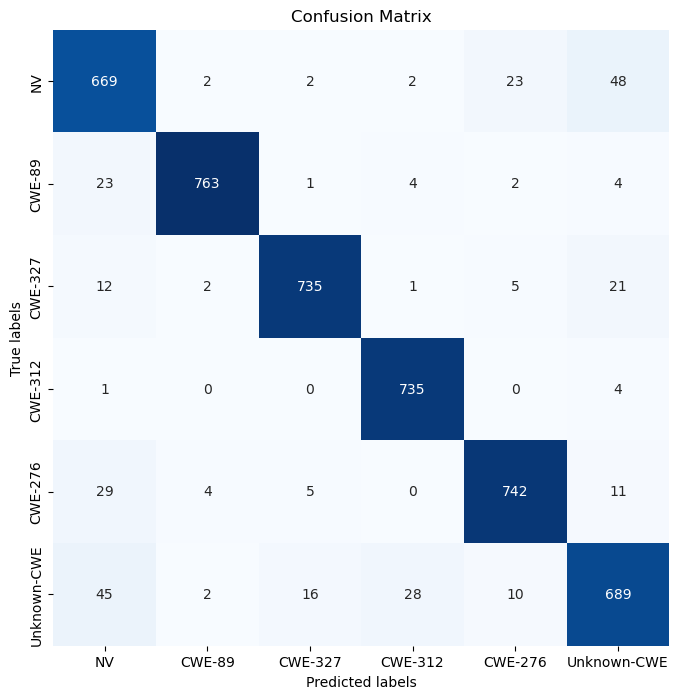

In [ ]:
from sklearn.metrics import confusion_matrix
matrix_confusion = confusion_matrix(pred_test,y_pred_test)
# confusion=multilabel_confusion_matrix(y_true=y_pred_test, y_pred=pred_test)
annot_kws = {
    0: "NV", 
    1: "CWE-89",
    2: "CWE-327",
    3: "CWE-312",
    4: "CWE-276",
    5: "UK"
}
figure = plt.figure(figsize=(8, 8))
sns.heatmap(matrix_confusion, square=True, annot=True, fmt='d', cmap='Blues',cbar=False,xticklabels=['NV', 'CWE-89', 'CWE-327', 'CWE-312', 'CWE-276', 'Unknown-CWE'],yticklabels=['NV', 'CWE-89', 'CWE-327', 'CWE-312', 'CWE-276', 'Unknown-CWE'])   
#
ax= plt.subplot()

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
#ax.xaxis.set_ticklabels(['NV', 'CWE-89', 'CWE-327', 'CWE-312', 'CWE-276', 'Unknown-CWE']); ax.yaxis.set_ticklabels(['NV', 'CWE-89', 'CWE-327', 'CWE-312', 'CWE-276', 'Unknown-CWE']);


In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

In [ ]:
# n_classes=len(predicted)
# precision = dict()
# recall = dict()
# for i in range(n_classes):
#     precision[i], recall[i], _ = precision_recall_curve(y_pred_test[:, i],
#                                                         predicted[:, i])
#     plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))
    
# plt.xlabel("recall")
# plt.ylabel("precision")
# plt.legend(loc="best")
# plt.title("precision vs. recall curve")
# plt.show()

In [ ]:
confusion

In [ ]:
#pred_test.shape

In [ ]:
#y_pred_test.shape

In [ ]:
import seaborn as sns

In [ ]:
data

,Name,Impact
0,static byte[] ntlm2SessionResponse(byte[] bArr...,0
1,this.md5 = MessageDigest.getInstance(FileSyste...,0
2,private static byte[] generateKeyFromPasswordS...,0
3,"this.mac = Mac.getInstance(""HmacMD5"");",0
4,public static byte[] getNTLM2Response(byte[] b...,0
...,...,...
51281,private static String a(byte[] bArr) \r\n ...,1
51282,"static void a(a.az r9, java.io.File r10) throw...",1
51283,public static void a(Runnable runnable) \r\n ...,1
51284,public static String c(Context context) \r\n ...,1


In [ ]:
list(data.columns[1:])

['Impact']

In [ ]:
len(pred_test), len(y_pred_test)


(10258, 10258)

In [ ]:
type(pred_test[0])

int

In [ ]:
len(pred_test), len(y_pred_test)

(10258, 10258)

In [ ]:
pred_test = np.array(pred_test)
y_pred_test = np.array(y_pred_test)

In [ ]:
# con_mat = tf.math.confusion_matrix(
#     #y_test_array_norm,
#     #pred_test_array_norm,
#     pred_test,
#     y_pred_test,
#     num_classes=2,
#     dtype=tf.int16
# ).numpy()

# con_mat_norm = np.around(con_mat.astype('int') / con_mat.sum(axis=1)[:, np.newaxis], decimals=1)

# index = ['NON-VUL, VUL']

# con_mat_df = pd.DataFrame(con_mat,
#                      index = None
#                      #columns = index
#                      )


# figure = plt.figure(figsize=(8, 8))
# sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
# plt.tight_layout()
# plt.ylabel('True label')
# plt.xlabel('Predicted label')
# plt.show()

In [ ]:
#con_mat_norm

In [ ]:
#con_mat

In [ ]:
np.where(y_pred_test[3] == pred_test[3])[0].shape

(1,)

In [ ]:
np.where(y_pred_test[3] != pred_test[3])[0].shape

(0,)

In [ ]:
y_pred_test[3][y_pred_test[3] == 1].__len__()

0

In [ ]:
pred_test[3][pred_test[3] == 0].__len__()

1

In [ ]:
pred_test[3][pred_test[3] == 1].__len__()

0

In [ ]:
#len(pred_test[3])

In [ ]:
y_pred_test[1].shape

()

In [ ]:
y_pred_test[1][y_pred_test[1] == 0].shape

(1,)

In [ ]:
pred_test[1][pred_test[1] == 1].shape

(0,)

In [ ]:
#pred_test[1][np.where(y_pred_test[1] != pred_test[1])].shape

In [ ]:
y_pred_test.shape

(10258,)

In [ ]:
# tf.math.confusion_matrix(
#     y_pred_test[1],
#     y_pred_test[1],
#     num_classes=1,
#     weights=None,
#     dtype=tf.dtypes.int64,
#     name=None   
# )

In [ ]:
y_pred_test = np.array(y_pred_test)
pred_test = np.array(pred_test)

In [ ]:
y_pred_test[0].shape, pred_test[0].shape

((), ())

In [ ]:
#pred_test[0][2]

In [ ]:
#y_pred_test[0][2]

In [ ]:
# confusion = sklearn.metrics.confusion_matrix(y_true=y_pred_test[2], y_pred=pred_test[2])
# print(confusion)

In [ ]:
len(pred_test)

10258

In [ ]:
# zero_count = 0
# one_count = 0
# for i in pred_test[2]:
#     if i == 0:
#         zero_count += 1
#     else:
#         one_count += 1


In [ ]:
# zero_count

In [ ]:
# one_count

In [ ]:
model.metrics_names

['loss', 'accuracy']

In [ ]:
model.metrics_names[1]

'accuracy'

### Plot The Model's Training History

In [ ]:
epochs_range = range(len(history.history[model.metrics_names[1]]))

fig, axs = plt.subplots(2, 2, figsize=(20,15))
fig.suptitle('CNN with 10 Epochs')


axs[0,0].plot(epochs_range, history.history['val_%s'%(model.metrics_names[1])], 'b', label='Impact', color='green')
# axs[0,0].plot(epochs_range, history.history['val_%s'%(model.metrics_names[13])], 'b', label='CWE-312', color='blue')
# axs[0,0].plot(epochs_range, history.history['val_%s'%(model.metrics_names[14])], 'b', label='CWE-295', color='red')
# axs[0,0].plot(epochs_range, history.history['val_%s'%(model.metrics_names[15])], 'b', label='CWE-276', color='purple')
# axs[0,0].plot(epochs_range, history.history['val_%s'%(model.metrics_names[16])], 'b', label='CWE-327', color='black')
# axs[0,0].plot(epochs_range, history.history['val_%s'%(model.metrics_names[17])], 'b', label='CWE-330', color='yellow')
# axs[0,0].plot(epochs_range, history.history['val_%s'%(model.metrics_names[18])], 'b', label='CWE-200', color='brown')
# axs[0,0].plot(epochs_range, history.history['val_%s'%(model.metrics_names[19])], 'b', label='CWE-89', color='cyan')
# axs[0,0].plot(epochs_range, history.history['val_%s'%(model.metrics_names[20])], 'b', label='CWE-919', color='orange')
# axs[0,0].plot(epochs_range, history.history['val_%s'%(model.metrics_names[21])], 'b', label='CWE-649', color='red')
# axs[0,0].plot(epochs_range, history.history['val_%s'%(model.metrics_names[22])], 'b', label='CWE-250', color='pink')

axs[0,0].set_title('Training accuracy')
axs[0,0].legend()


axs[0,1].plot(epochs_range, history.history['val_%s'%(model.metrics_names[0])], 'b', label='Impact', color='green')
# axs[0,1].plot(epochs_range, history.history['val_%s'%(model.metrics_names[2])], 'b', label='CWE-312', color='blue')
# axs[0,1].plot(epochs_range, history.history['val_%s'%(model.metrics_names[3])], 'b', label='CWE-295', color='red')
# axs[0,1].plot(epochs_range, history.history['val_%s'%(model.metrics_names[4])], 'b', label='CWE-276', color='purple')
# axs[0,1].plot(epochs_range, history.history['val_%s'%(model.metrics_names[5])], 'b', label='CWE-327', color='black')
# axs[0,1].plot(epochs_range, history.history['val_%s'%(model.metrics_names[6])], 'b', label='CWE-330', color='yellow')
# axs[0,1].plot(epochs_range, history.history['val_%s'%(model.metrics_names[7])], 'b', label='CWE-200', color='brown')
# axs[0,1].plot(epochs_range, history.history['val_%s'%(model.metrics_names[8])], 'b', label='CWE-89', color='cyan')
# axs[0,1].plot(epochs_range, history.history['val_%s'%(model.metrics_names[9])], 'b', label='CWE-919', color='orange')
# axs[0,1].plot(epochs_range, history.history['val_%s'%(model.metrics_names[10])], 'b', label='CWE-649', color='red')
# axs[0,1].plot(epochs_range, history.history['val_%s'%(model.metrics_names[11])], 'b', label='CWE-250', color='pink')

axs[0,1].set_title('Training Loss')
axs[0,1].legend()

axs[1,0].plot(epochs_range, history.history['val_%s'%(model.metrics_names[1])], 'b', label='Impact', color='green')
# axs[1,0].plot(epochs_range, history.history['val_%s'%(model.metrics_names[13])], 'b', label='CWE-312', color='blue')
# axs[1,0].plot(epochs_range, history.history['val_%s'%(model.metrics_names[14])], 'b', label='CWE-295', color='red')
# axs[1,0].plot(epochs_range, history.history['val_%s'%(model.metrics_names[15])], 'b', label='CWE-276', color='purple')
# axs[1,0].plot(epochs_range, history.history['val_%s'%(model.metrics_names[16])], 'b', label='CWE-327', color='black')
# axs[1,0].plot(epochs_range, history.history['val_%s'%(model.metrics_names[17])], 'b', label='CWE-330', color='yellow')
# axs[1,0].plot(epochs_range, history.history['val_%s'%(model.metrics_names[18])], 'b', label='CWE-200', color='brown')
# axs[1,0].plot(epochs_range, history.history['val_%s'%(model.metrics_names[19])], 'b', label='CWE-89', color='cyan')
# axs[1,0].plot(epochs_range, history.history['val_%s'%(model.metrics_names[20])], 'b', label='CWE-919', color='orange')
# axs[1,0].plot(epochs_range, history.history['val_%s'%(model.metrics_names[21])], 'b', label='CWE-649', color='red')
# axs[1,0].plot(epochs_range, history.history['val_%s'%(model.metrics_names[22])], 'b', label='CWE-250', color='pink')

axs[1,0].legend()


axs[1,1].plot(epochs_range, history.history['val_%s'%(model.metrics_names[0])], 'b', label='Impact', color='green')
# axs[1,1].plot(epochs_range, history.history['val_%s'%(model.metrics_names[2])], 'b', label='CWE-312', color='blue')
# axs[1,1].plot(epochs_range, history.history['val_%s'%(model.metrics_names[3])], 'b', label='CWE-295', color='red')
# axs[1,1].plot(epochs_range, history.history['val_%s'%(model.metrics_names[4])], 'b', label='CWE-276', color='purple')
# axs[1,1].plot(epochs_range, history.history['val_%s'%(model.metrics_names[5])], 'b', label='CWE-327', color='black')
# axs[1,1].plot(epochs_range, history.history['val_%s'%(model.metrics_names[6])], 'b', label='CWE-330', color='yellow')
# axs[1,1].plot(epochs_range, history.history['val_%s'%(model.metrics_names[7])], 'b', label='CWE-200', color='brown')
# axs[1,1].plot(epochs_range, history.history['val_%s'%(model.metrics_names[8])], 'b', label='CWE-89', color='cyan')
# axs[1,1].plot(epochs_range, history.history['val_%s'%(model.metrics_names[9])], 'b', label='CWE-919', color='orange')
# axs[1,1].plot(epochs_range, history.history['val_%s'%(model.metrics_names[10])], 'b', label='CWE-649', color='red')
# axs[1,1].plot(epochs_range, history.history['val_%s'%(model.metrics_names[11])], 'b', label='CWE-250', color='pink')

axs[1,1].set_title('Validation Loss')
axs[1,1].legend()


In [ ]:
max(history.history['val_accuracy'])

In [ ]:
history.history.keys()

In [ ]:
'val_%s'%(model.metrics_names[1])

'val_accuracy'